In [1]:
from PIL import Image

# Path to the original image
image_path = r'cropped_sample_512.png'

# Open the image
image = Image.open(image_path)

# Get dimensions of the image
width, height = image.size
width1, height1 = 512,512
# Calculate coordinates for cropping
left = (width - width1) / 2
top = (height - height1) / 2
right = (width + width1) / 2
bottom = (height + height1) / 2

# Crop the image
cropped_image = image.crop((left, top, right, bottom))

# Save the cropped image
cropped_image_path = r'test_image.png'  # Specify path for cropped image
cropped_image.save(cropped_image_path)

print(f"Cropped image saved at: {cropped_image_path}")

Cropped image saved at: test_image.png


In [2]:
from PIL import Image

def enlarge_image(input_path, output_path, new_size=(4094, 2400)):
    # 打开原始图片
    original_image = Image.open(input_path)
    original_width, original_height = original_image.size

    # new back
    new_image = Image.new("RGB", new_size, (255, 255, 255))

    # central point
    top_left_x = (new_size[0] - original_width) // 2
    top_left_y = (new_size[1] - original_height) // 2

    # in large place
    new_image.paste(original_image, (top_left_x, top_left_y))

    # 保存新图像
    new_image.save(output_path)

# 使用示例
input_image_path = 'test_image.png'  # 替换为您的图片路径

output_image_path = 'enlarged_original_image.png'  # 替换为保存路径
enlarge_image(input_image_path, output_image_path)

In [3]:
import sys
import os
import odak
import numpy as np
import torch


def test(output_directory = 'test_output'):
    odak.tools.check_directory(output_directory)
    resolution = [2400, 4094]
    wavelengths = [639e-9, 515e-9, 473e-9]
    pixel_pitch = 3.74e-6
    number_of_frames = 3
    number_of_depth_layers = 3
    volume_depth = 5e-3
    image_location_offset = 0.
    propagation_type = 'Bandlimited Angular Spectrum'
    propagator_type = 'forward'
    laser_channel_power = None
    aperture = None
    aperture_size = 1800
    method = 'conventional'
    device = torch.device('cpu')
    hologram_phases_filename = 'enlarged_original_image.png'
    hologram_phases = odak.learn.tools.load_image(
                                                  hologram_phases_filename,
                                                  normalizeby = 255.,
                                                  torch_style = True
                                                 ).to(device) * odak.pi * 2
    propagator = odak.learn.wave.propagator(
                                            resolution = resolution,
                                            wavelengths = wavelengths,
                                            pixel_pitch = pixel_pitch,
                                            number_of_frames = number_of_frames,
                                            number_of_depth_layers = number_of_depth_layers,
                                            volume_depth = volume_depth,
                                            image_location_offset = image_location_offset,
                                            propagation_type = propagation_type,
                                            propagator_type = propagator_type,
                                            laser_channel_power = laser_channel_power,
                                            aperture_size = aperture_size,
                                            aperture = aperture,
                                            method = method,
                                            device = device
                                           )
    reconstruction_intensities = propagator.reconstruct(hologram_phases, amplitude = None)
    reconstruction_intensities = torch.sum(reconstruction_intensities, axis = 0)
    for depth_id, reconstruction_intensity in enumerate(reconstruction_intensities):
        odak.learn.tools.save_image(
                                    '{}/reconstruction_image_{:03d}.png'.format(output_directory, depth_id),
                                    reconstruction_intensity,
                                    cmin = 0.,
                                    cmax = 1.
                                   )
    assert True == True

if __name__ == '__main__':
    test()
# if __name__ == '__main__':
#     sys.exit(test())

Cropped image saved at: original_recor_output\cropped_reconstruction_image_000.png


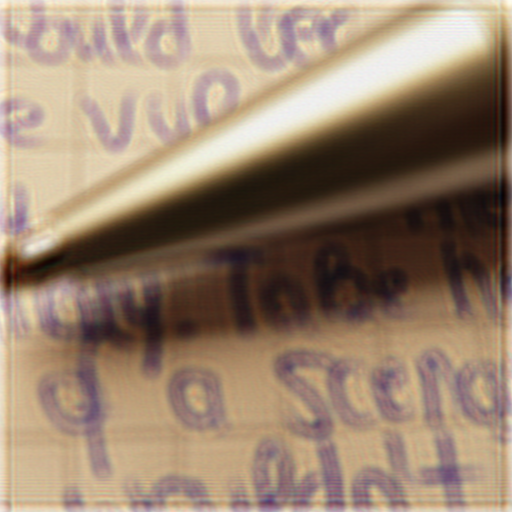

Cropped image saved at: original_recor_output\cropped_reconstruction_image_001.png


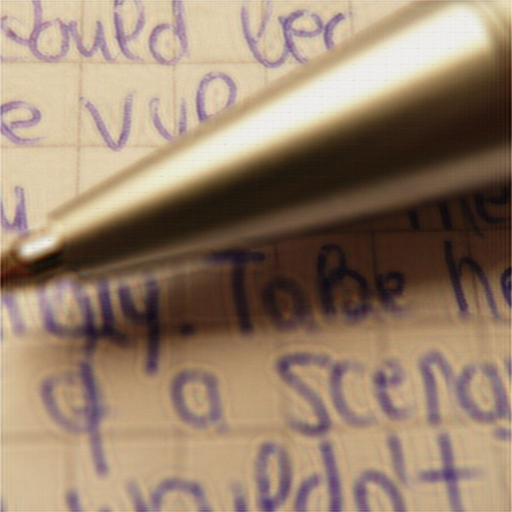

Cropped image saved at: original_recor_output\cropped_reconstruction_image_002.png


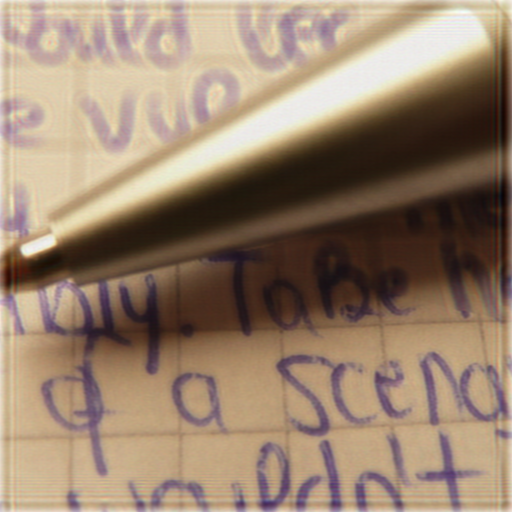

In [4]:
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cropped_folder = 'original_recor_output'
os.makedirs(cropped_folder, exist_ok=True)
# 三张原始图片路径
image_paths = [
    'test_output/reconstruction_image_000.png',
    'test_output/reconstruction_image_001.png',
    'test_output/reconstruction_image_002.png'
]

# 循环处理每一张图片
for i, path in enumerate(image_paths):

    image = Image.open(path)
    width, height = image.size
    width1, height1 = 512, 512

    # crop
    left = (width - width1) / 2
    top = (height - height1) / 2
    right = (width + width1) / 2
    bottom = (height + height1) / 2
    cropped_image = image.crop((left, top, right, bottom))

    # save
    cropped_output_path = os.path.join(cropped_folder, f'cropped_reconstruction_image_{i:03d}.png')
    cropped_image.save(cropped_output_path)
    print(f"Cropped image saved at: {cropped_output_path}")

    # display
    display(cropped_image)

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchsummary import summary
import random
import copy
# early stop
class EarlyStopping:
    def __init__(self, patience=1000, delta=0.000001,stop_threshold=0.000008):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop_threshold = stop_threshold
    def __call__(self, current_loss):
        if current_loss < self.stop_threshold:
            print(f"Loss reached threshold {self.stop_threshold}, early stopping")
            return True
        if current_loss < self.best_loss - self.delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

# seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed}")
# network
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, omega_0=30, is_first=False):
        super().__init__()
        self.is_first = is_first
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # 第一层初始化
                self.linear.weight.uniform_(-1 / self.linear.in_features,
                                            1 / self.linear.in_features)
            else:
                # 后续层初始化
                self.linear.weight.uniform_(-np.sqrt(6 / self.linear.in_features) / self.omega_0,
                                            np.sqrt(6 / self.linear.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, is_first=False, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)

        # 修正初始化策略
        with torch.no_grad():
            if self.is_first:
                bound = 1 / in_features
            else:
                bound = np.sqrt(6 / in_features) / omega_0
            self.linear.weight.uniform_(-bound, bound)
            if self.linear.bias is not None:
                self.linear.bias.uniform_(-bound, bound)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class Siren(nn.Module):
    def __init__(self, in_features=2, hidden_features=64, hidden_layers=6, out_features=3):
        super().__init__()
        self.net = nn.ModuleList()

        # 第一层特殊处理
        self.net.append(SineLayer(in_features, hidden_features, is_first=True))

        # 中间层
        for _ in range(hidden_layers-2):
            self.net.append(SineLayer(hidden_features, hidden_features))
        self.net.append(SineLayer(hidden_features, 16))

        # 输出层修正
        self.final_layer = nn.Sequential(
            nn.Linear(16, out_features),
            nn.Sigmoid()
        )
        # 输出层初始化
        with torch.no_grad():
            self.final_layer[0].weight.uniform_(-np.sqrt(6/hidden_features),
                                             np.sqrt(6/hidden_features))

    def forward(self, coords):
        x = coords
        for layer in self.net:
            x = layer(x)
        return self.final_layer(x)

def extract_patch_data(patch_img):
    patch_np = np.array(patch_img)
    h, w, _ = patch_np.shape
    y_coords, x_coords = np.indices((h, w))
    coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2)
    rgb_values = patch_np.reshape(-1, 3) / 255.0
    return coords, rgb_values, h, w

# train
def train_siren(model, coords, rgb_values, device, total_steps=15000, steps_til_summary=2000):
    coords_tensor = torch.tensor(coords, dtype=torch.float32).to(device)
    rgb_values_tensor = torch.tensor(rgb_values, dtype=torch.float32).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)

    early_stopping = EarlyStopping(patience=5000, delta=0.00001)  # 新增早停实例

    for step in range(total_steps):
        optimizer.zero_grad()
        pred = model(coords_tensor)
        loss = criterion(pred, rgb_values_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # 早停检查
        # if step > 5000:  # 前10000步不检查早停
        if early_stopping(loss.item()):
            print(f"Early stopping at step {step}, Loss: {loss.item():.6f}")
            break

        if step % steps_til_summary == 0:
            print(f"Step {step}/{total_steps}, Loss: {loss.item():.6f}")
    return model

def generate_patch(model, device, patch_size, actual_size):
    h, w = actual_size
    y_coords, x_coords = np.indices((h, w))
    coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2)

    coords_tensor = torch.tensor(coords, dtype=torch.float32).to(device)
    with torch.no_grad():
        rgb_output = model(coords_tensor).cpu().numpy()

    rgb_output = (np.clip(rgb_output, 0, 1) * 255).astype(np.uint8)
    return rgb_output.reshape(h, w, 3)

# overlap
def create_weight_mask(patch_size, overlap):
    """mask"""
    mask = np.ones((patch_size, patch_size, 3), dtype=np.float32)

    # x
    for i in range(overlap):
        ratio = i / (overlap - 1)
        mask[:, i] *= ratio
        mask[:, -(i+1)] *= ratio

    # y
    for j in range(overlap):
        ratio = j / (overlap - 1)
        mask[j, :] *= ratio
        mask[-(j+1), :] *= ratio

    return mask

if __name__ == "__main__":
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_path = r"test_image.png"
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)

    full_img = Image.open(image_path).convert('RGB')
    original_width, original_height = full_img.size

    # ovelap
    patch_size = 64
    overlap = patch_size//4
    stride = patch_size - overlap

    num_x = (original_width - overlap + stride - 1) // stride
    num_y = (original_height - overlap + stride - 1) // stride

    # train based on last
    regenerated_sum = np.zeros((original_height, original_width, 3), dtype=np.float32)
    weight_sum = np.zeros((original_height, original_width, 3), dtype=np.float32)
    weight_mask = create_weight_mask(patch_size, overlap)

    prev_state_dict = None

    for i in range(num_x):
        for j in range(num_y):
            left = i * stride
            upper = j * stride
            right = min(left + patch_size, original_width)
            lower = min(upper + patch_size, original_height)

            if i == num_x - 1:
                left = original_width - patch_size
            if j == num_y - 1:
                upper = original_height - patch_size

            patch = full_img.crop((left, upper, right, lower))
            coords, rgb_values, h_patch, w_patch = extract_patch_data(patch)

            # 创建模型并继承权重 -------------------
            model = Siren(hidden_features=32).to(device)
            if prev_state_dict is not None:
                model.load_state_dict(prev_state_dict)
                print(f"Loaded weights from previous patch")
            if i==0 and j==0:
                summary(model, (2,))
            print(f"Training patch ({i},{j}) at [{left}:{right}, {upper}:{lower}]...")
            trained_model = train_siren(model, coords, rgb_values, device)

            # 保存当前模型权重供下一个patch使用
            prev_state_dict = copy.deepcopy(trained_model.state_dict())

            model_path = os.path.join(output_folder, f"model_{i}_{j}.pth")
            torch.save(trained_model.state_dict(), model_path)

            patch_array = generate_patch(trained_model, device, patch_size, (h_patch, w_patch))

            actual_h, actual_w = lower - upper, right - left
            cropped_mask = weight_mask[:actual_h, :actual_w, :]

            patch_float = patch_array.astype(np.float32)

            regenerated_sum[upper:lower, left:right] += patch_float * cropped_mask
            weight_sum[upper:lower, left:right] += cropped_mask

    regenerated = np.zeros_like(regenerated_sum)
    valid_mask = weight_sum > 1e-6
    regenerated[valid_mask] = regenerated_sum[valid_mask] / weight_sum[valid_mask]
    regenerated = np.clip(regenerated, 0, 255).astype(np.uint8)

    Image.fromarray(regenerated).save("generated_image.png")
    print("Reconstruction with sequential weight inheritance complete!")

Random seed set to 42
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              96
         SineLayer-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
         SineLayer-4                   [-1, 32]               0
            Linear-5                   [-1, 32]           1,056
         SineLayer-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
         SineLayer-8                   [-1, 32]               0
            Linear-9                   [-1, 32]           1,056
        SineLayer-10                   [-1, 32]               0
           Linear-11                   [-1, 16]             528
        SineLayer-12                   [-1, 16]               0
           Linear-13                    [-1, 3]              51
          Sigmoid

In [6]:
from PIL import Image

def enlarge_image(input_path, output_path, new_size=(4094, 2400)):
    # 打开原始图片
    original_image = Image.open(input_path)
    original_width, original_height = original_image.size

    # new back
    new_image = Image.new("RGB", new_size, (255, 255, 255))

    # central point
    top_left_x = (new_size[0] - original_width) // 2
    top_left_y = (new_size[1] - original_height) // 2

    # in large place
    new_image.paste(original_image, (top_left_x, top_left_y))

    # 保存新图像
    new_image.save(output_path)

# 使用示例
input_image_path = 'generated_image.png'  # 替换为您的图片路径

output_image_path = 'enlarged_new_image.png'  # 替换为保存路径
enlarge_image(input_image_path, output_image_path)

In [7]:
import sys
import os
import odak
import numpy as np
import torch


def test(output_directory = 'test_newoutput'):
    odak.tools.check_directory(output_directory)
    resolution = [2400, 4094]
    wavelengths = [639e-9, 515e-9, 473e-9]
    pixel_pitch = 3.74e-6
    number_of_frames = 3
    number_of_depth_layers = 3
    volume_depth = 5e-3
    image_location_offset = 0.
    propagation_type = 'Bandlimited Angular Spectrum'
    propagator_type = 'forward'
    laser_channel_power = None
    aperture = None
    aperture_size = 1800
    method = 'conventional'
    device = torch.device('cpu')
    hologram_phases_filename = 'enlarged_new_image.png'
    hologram_phases = odak.learn.tools.load_image(
                                                  hologram_phases_filename,
                                                  normalizeby = 255.,
                                                  torch_style = True
                                                 ).to(device) * odak.pi * 2
    propagator = odak.learn.wave.propagator(
                                            resolution = resolution,
                                            wavelengths = wavelengths,
                                            pixel_pitch = pixel_pitch,
                                            number_of_frames = number_of_frames,
                                            number_of_depth_layers = number_of_depth_layers,
                                            volume_depth = volume_depth,
                                            image_location_offset = image_location_offset,
                                            propagation_type = propagation_type,
                                            propagator_type = propagator_type,
                                            laser_channel_power = laser_channel_power,
                                            aperture_size = aperture_size,
                                            aperture = aperture,
                                            method = method,
                                            device = device
                                           )
    reconstruction_intensities = propagator.reconstruct(hologram_phases, amplitude = None)
    reconstruction_intensities = torch.sum(reconstruction_intensities, axis = 0)
    for depth_id, reconstruction_intensity in enumerate(reconstruction_intensities):
        odak.learn.tools.save_image(
                                    '{}/reconstruction_image_{:03d}.png'.format(output_directory, depth_id),
                                    reconstruction_intensity,
                                    cmin = 0.,
                                    cmax = 1.
                                   )
    assert True == True

if __name__ == '__main__':
    test()
# if __name__ == '__main__':
#     sys.exit(test())

Cropped image saved at: new_recor_output\cropped_reconstruction_image_000.png


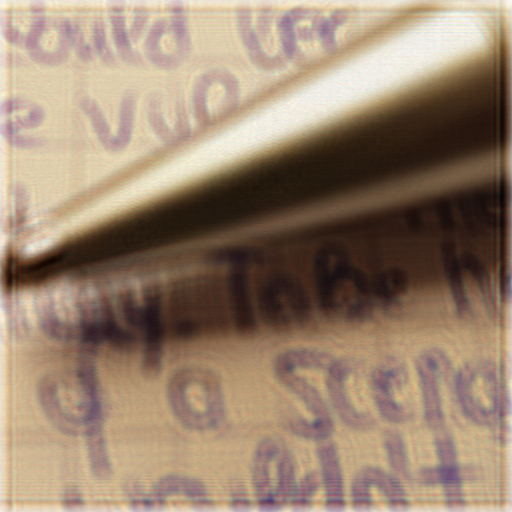

Cropped image saved at: new_recor_output\cropped_reconstruction_image_001.png


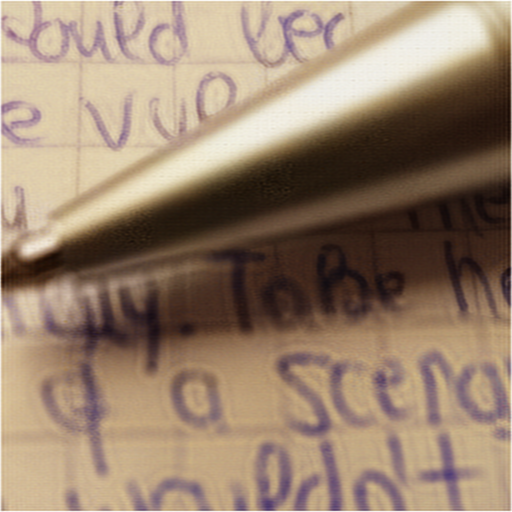

Cropped image saved at: new_recor_output\cropped_reconstruction_image_002.png


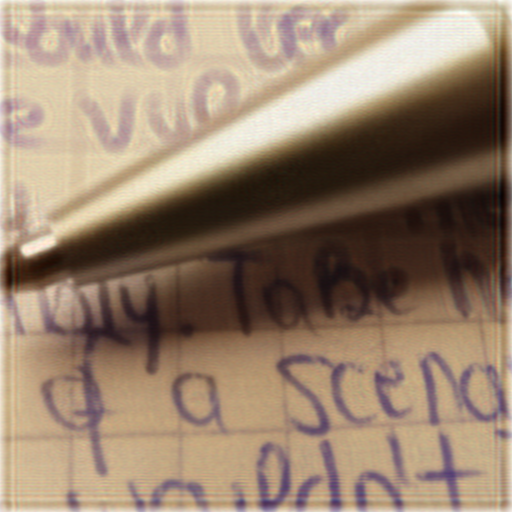

In [8]:
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cropped_folder = 'new_recor_output'
os.makedirs(cropped_folder, exist_ok=True)
# 三张原始图片路径
image_paths = [
    'test_newoutput/reconstruction_image_000.png',
    'test_newoutput/reconstruction_image_001.png',
    'test_newoutput/reconstruction_image_002.png'
]

# 循环处理每一张图片
for i, path in enumerate(image_paths):

    image = Image.open(path)
    width, height = image.size
    width1, height1 = 512, 512

    # crop
    left = (width - width1) / 2
    top = (height - height1) / 2
    right = (width + width1) / 2
    bottom = (height + height1) / 2
    cropped_image = image.crop((left, top, right, bottom))

    # save
    cropped_output_path = os.path.join(cropped_folder, f'cropped_reconstruction_image_{i:03d}.png')
    cropped_image.save(cropped_output_path)
    print(f"Cropped image saved at: {cropped_output_path}")

    # display
    display(cropped_image)

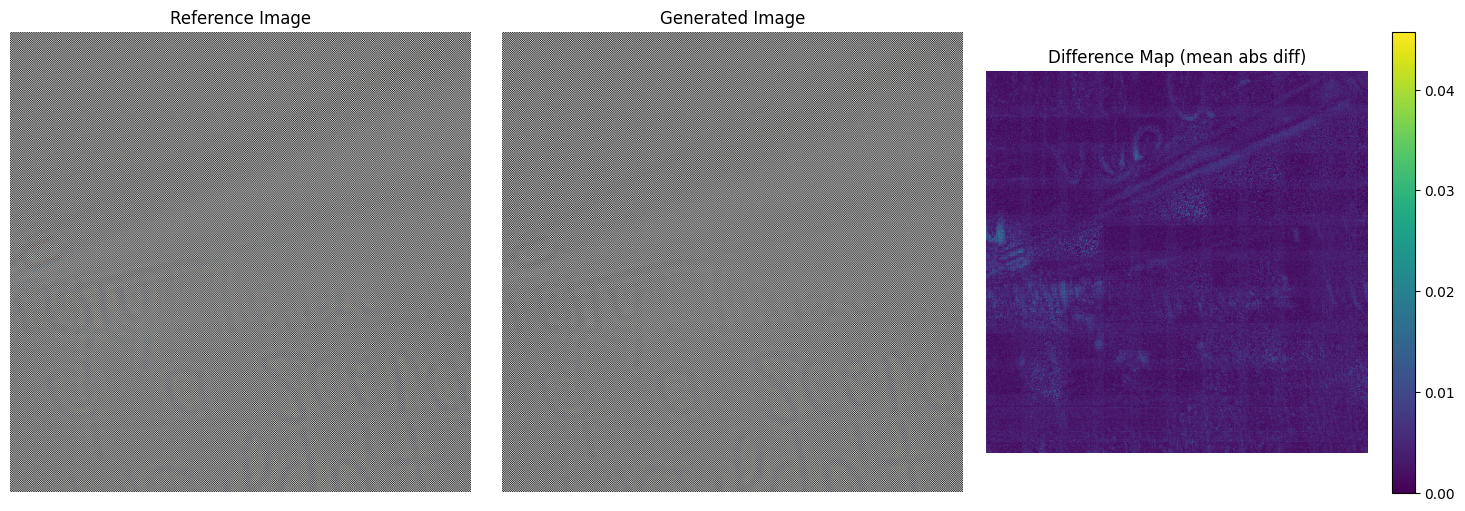

PSNR: 46.3076 dB
SSIM: 0.9958


In [5]:
import torch
from PIL import Image
import piq
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def calculate_psnr_ssim(
    ref_path, gen_path, 
    device='cuda' if torch.cuda.is_available() else 'cpu',
    border_crop=0  # 边缘裁剪像素数，默认不裁剪
):
    # 读图
    ref_img = Image.open(ref_path).convert('RGB')
    gen_img = Image.open(gen_path).convert('RGB')

    # 转numpy
    ref_np = np.array(ref_img).astype(np.float32) / 255.0
    gen_np = np.array(gen_img).astype(np.float32) / 255.0

    # # 自动resize第二张到第一张尺寸
    # if ref_np.shape != gen_np.shape:
    #     gen_img = gen_img.resize(ref_img.size, resample=Image.BILINEAR)
    #     gen_np = np.array(gen_img).astype(np.float32) / 255.0

    # 裁剪边缘
    if border_crop > 0:
        ref_np = ref_np[border_crop:-border_crop, border_crop:-border_crop, :]
        gen_np = gen_np[border_crop:-border_crop, border_crop:-border_crop, :]

    # 转Tensor，CHW格式
    ref_tensor = torch.tensor(ref_np).permute(2, 0, 1).unsqueeze(0).to(device)
    gen_tensor = torch.tensor(gen_np).permute(2, 0, 1).unsqueeze(0).to(device)

    # 计算指标
    psnr_val = piq.psnr(gen_tensor, ref_tensor, data_range=1.0).item()
    ssim_val = piq.ssim(gen_tensor, ref_tensor, data_range=1.0).item()

    # 差异图
    diff_map = np.mean(np.abs(ref_np - gen_np), axis=2)

    # 可视化
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Reference Image')
    plt.imshow(ref_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(gen_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Difference Map (mean abs diff)')
    plt.imshow(diff_map, cmap='viridis')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {'PSNR': psnr_val, 'SSIM': ssim_val}


if __name__ == "__main__":
    ref_img = 'cropped_sample_512.png'
    gen_img = 'generated_image.png'

    results = calculate_psnr_ssim(ref_img, gen_img, border_crop=2)
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")


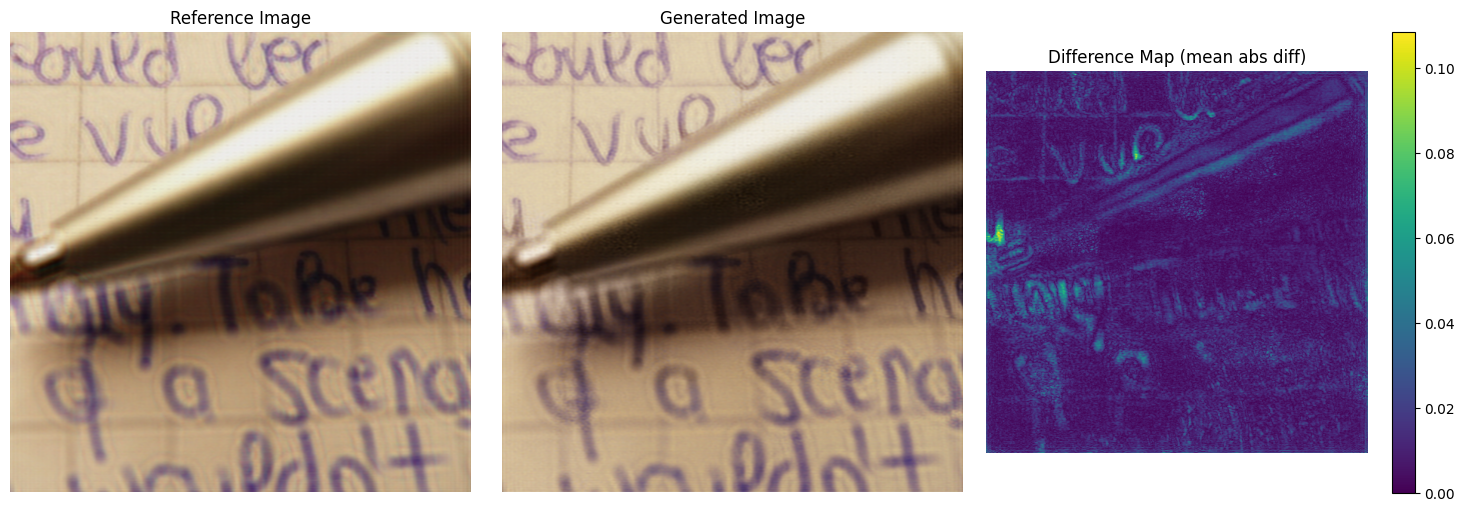

PSNR: 36.2462 dB
SSIM: 0.9622


In [18]:
import torch
from PIL import Image
import piq
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def calculate_psnr_ssim(
    ref_path, gen_path, 
    device='cuda' if torch.cuda.is_available() else 'cpu',
    border_crop=0  # 边缘裁剪像素数，默认不裁剪
):
    # 读图
    ref_img = Image.open(ref_path).convert('RGB')
    gen_img = Image.open(gen_path).convert('RGB')

    # 转numpy
    ref_np = np.array(ref_img).astype(np.float32) / 255.0
    gen_np = np.array(gen_img).astype(np.float32) / 255.0

    # 自动resize第二张到第一张尺寸
    if ref_np.shape != gen_np.shape:
        gen_img = gen_img.resize(ref_img.size, resample=Image.BILINEAR)
        gen_np = np.array(gen_img).astype(np.float32) / 255.0

    # 裁剪边缘
    if border_crop > 0:
        ref_np = ref_np[border_crop:-border_crop, border_crop:-border_crop, :]
        gen_np = gen_np[border_crop:-border_crop, border_crop:-border_crop, :]

    # 转Tensor，CHW格式
    ref_tensor = torch.tensor(ref_np).permute(2, 0, 1).unsqueeze(0).to(device)
    gen_tensor = torch.tensor(gen_np).permute(2, 0, 1).unsqueeze(0).to(device)

    # 计算指标
    psnr_val = piq.psnr(gen_tensor, ref_tensor, data_range=1.0).item()
    ssim_val = piq.ssim(gen_tensor, ref_tensor, data_range=1.0).item()

    # 差异图
    diff_map = np.mean(np.abs(ref_np - gen_np), axis=2)

    # 可视化
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Reference Image')
    plt.imshow(ref_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(gen_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Difference Map (mean abs diff)')
    plt.imshow(diff_map, cmap='viridis')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {'PSNR': psnr_val, 'SSIM': ssim_val}

img1_path = 'original_recor_output/cropped_reconstruction_image_001.png'
img2_path = 'new_recor_output/cropped_reconstruction_image_001.png'
if __name__ == "__main__":
    ref_img = img1_path
    gen_img = img2_path

    results = calculate_psnr_ssim(ref_img, gen_img, border_crop=3)
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")


c:\Users\25217\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\25217\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PSNR: 30.9499
SSIM: 0.9614
LPIPS: 0.1790
Image 1:


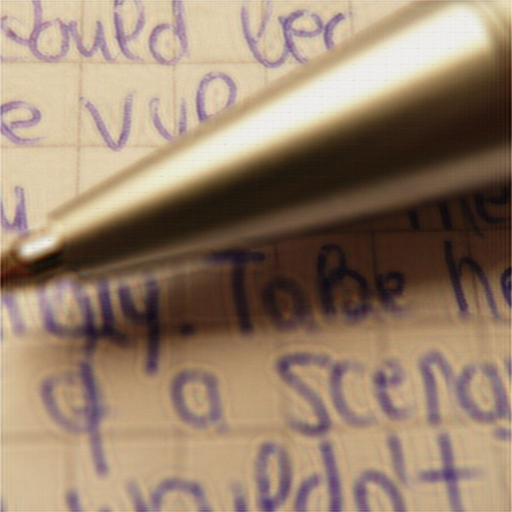

Image 2:


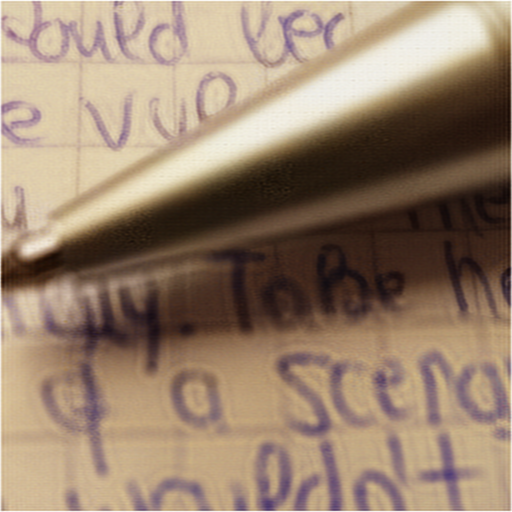

In [10]:
import torch
from PIL import Image
import torchvision.transforms as T
import piq

# Tensor
def load_image_as_tensor(path, device):
    image = Image.open(path).convert('RGB')
    transform = T.Compose([
        T.ToTensor(),
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    return tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image
img1_path = 'original_recor_output/cropped_reconstruction_image_001.png'
img2_path = 'new_recor_output/cropped_reconstruction_image_001.png'
pil_img1 = Image.open(img1_path)
pil_img2 = Image.open(img2_path)
img1 = load_image_as_tensor(img1_path, device)
img2 = load_image_as_tensor(img2_path, device)

# PSNR
psnr_val = piq.psnr(img1, img2, data_range=1.0).item()

# SSIM
ssim_val = piq.ssim(img1, img2, data_range=1.0).item()

# LPIPS
lpips_metric = piq.LPIPS()
lpips_metric = lpips_metric.to(device)
lpips_val = lpips_metric(img1, img2).item()

print(f"PSNR: {psnr_val:.4f}")
print(f"SSIM: {ssim_val:.4f}")
print(f"LPIPS: {lpips_val:.4f}")
print("Image 1:")
display(pil_img1)
print("Image 2:")
display(pil_img2)

PSNR: 33.9536
SSIM: 0.9377
LPIPS: 0.1707
Image 1:


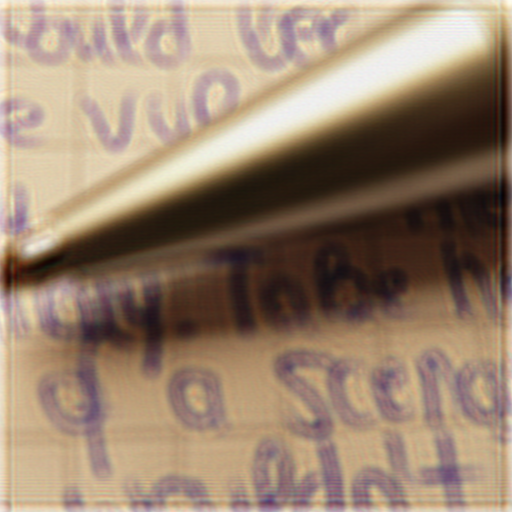

Image 2:


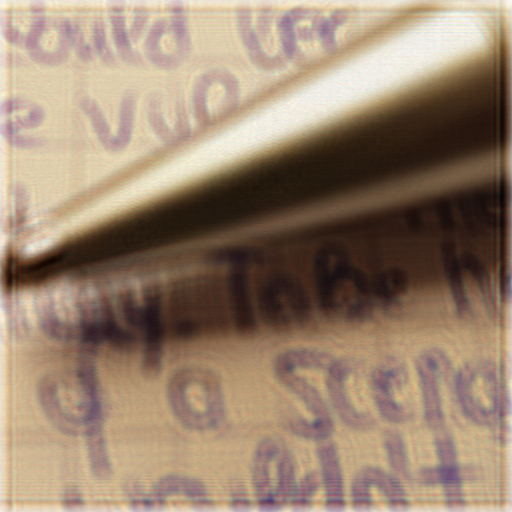

In [11]:
import torch
from PIL import Image
import torchvision.transforms as T
import piq

# Tensor
def load_image_as_tensor(path, device):
    image = Image.open(path).convert('RGB')
    transform = T.Compose([
        T.ToTensor(),
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    return tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image
img1_path = 'original_recor_output/cropped_reconstruction_image_000.png'
img2_path = 'new_recor_output/cropped_reconstruction_image_000.png'
pil_img1 = Image.open(img1_path)
pil_img2 = Image.open(img2_path)
img1 = load_image_as_tensor(img1_path, device)
img2 = load_image_as_tensor(img2_path, device)

# PSNR
psnr_val = piq.psnr(img1, img2, data_range=1.0).item()

# SSIM
ssim_val = piq.ssim(img1, img2, data_range=1.0).item()

# LPIPS
lpips_metric = piq.LPIPS()
lpips_metric = lpips_metric.to(device)
lpips_val = lpips_metric(img1, img2).item()

print(f"PSNR: {psnr_val:.4f}")
print(f"SSIM: {ssim_val:.4f}")
print(f"LPIPS: {lpips_val:.4f}")
print("Image 1:")
display(pil_img1)
print("Image 2:")
display(pil_img2)

PSNR: 33.8388
SSIM: 0.9384
LPIPS: 0.1664
Image 1:


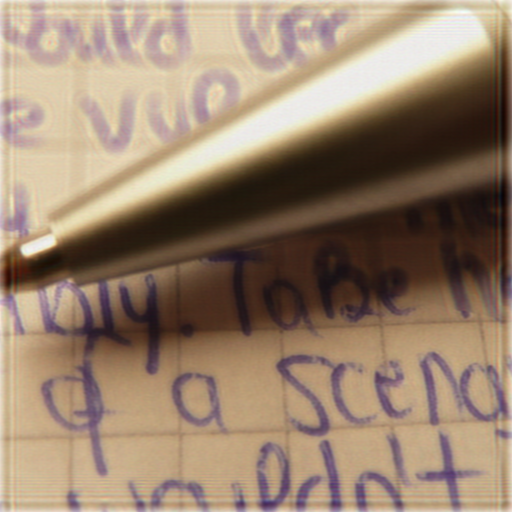

Image 2:


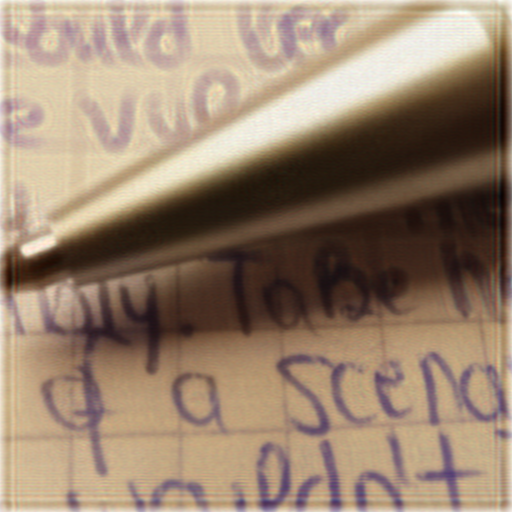

In [12]:
import torch
from PIL import Image
import torchvision.transforms as T
import piq

# Tensor
def load_image_as_tensor(path, device):
    image = Image.open(path).convert('RGB')
    transform = T.Compose([
        T.ToTensor(),
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    return tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image
img1_path = 'original_recor_output/cropped_reconstruction_image_002.png'
img2_path = 'new_recor_output/cropped_reconstruction_image_002.png'
pil_img1 = Image.open(img1_path)
pil_img2 = Image.open(img2_path)
img1 = load_image_as_tensor(img1_path, device)
img2 = load_image_as_tensor(img2_path, device)

# PSNR
psnr_val = piq.psnr(img1, img2, data_range=1.0).item()

# SSIM
ssim_val = piq.ssim(img1, img2, data_range=1.0).item()

# LPIPS
lpips_metric = piq.LPIPS()
lpips_metric = lpips_metric.to(device)
lpips_val = lpips_metric(img1, img2).item()

print(f"PSNR: {psnr_val:.4f}")
print(f"SSIM: {ssim_val:.4f}")
print(f"LPIPS: {lpips_val:.4f}")
print("Image 1:")
display(pil_img1)
print("Image 2:")
display(pil_img2)